In [1]:
from z3 import *
from itertools import combinations
import time
import numpy as np

### ROTATION MODEL

# Aux functions

# start_times = x and y coords
# durations and resources = x and y dims
# total = width / height
def cumulative(start_times, durations, resources, total):
    cumulative_expression = []
    for resource in resources:
        cumulative_expression.append(
            sum([
                If(And(start_times[s] <= resource, resource < start_times[s] + durations[s]), 
                resources[s], 
                0) 
                for s in range(len(start_times))
            ]) <= total
        )
    #print(cumulative_expression)
    return cumulative_expression

def maximum(array):
    maximum = array[0]
    for value in array[1:]:
        maximum = If(value > maximum, value, maximum)
    return maximum

# Instance 
class Instance(object):
    width = 0
    n = 0
    dimensions = []
    def __init__(self, width, n, dimensions):
        self.width = width
        self.n = n
        self.dimensions = dimensions

# Read instances: 
def read_file(file_name):
    dimensions = []
    with open(file_name) as f:
        width = int(f.readline())                 # Width of the plate
        n = int(f.readline())                     # Number of blocks
        while True:
            line = f.readline()
            if not line: 
                break
            dimensions.append(line.split(" "))    # Dimensions of each plate
    for dim in dimensions:
        dim[0] = int(dim[0])
        dim[1] = int(dim[1])
    instance = Instance(width, n, dimensions)
    return instance


# Solve instance
def solve(instance):
    optimizer = Optimize()

    # Variable Initalization
    optimizer.set("timeout", 300*1000) 

    x_dims=[]
    y_dims=[]
    x_dims_rotated = []
    y_dims_rotated = []
    x_coords = []
    y_coords = []
    rotation = [Bool("r%s" % str(i+1)) for i in range(instance.n)]

    for x_dim,y_dim in instance.dimensions:
        x_dims.append(x_dim)
        y_dims.append(y_dim)
        
    for block in range(instance.n):
        if(And(x_dims[block] != y_dims[block]), rotation[block]):
            x_dims_rotated.append(y_dims[block])
            y_dims_rotated.append(x_dims[block])
        else:
            x_dims_rotated.append(x_dims[block])
            y_dims_rotated.append(y_dims[block])
    
    for block in range(instance.n):
        x_coords.append(Int("x%s" % str(block+1)))
        y_coords.append(Int("y%s" % str(block+1)))

    max_height = math.ceil(sum(y_dims)/(instance.width//max(x_dims)))

    print("Width of the plate: ")
    print(instance.width)
    print("Max height of the plate: ")
    print(max_height)

    # Bounding the domain
    
    optimizer.add([x_coords[block] >= 0 for block in range(instance.n)]) # x domain
    optimizer.add([y_coords[block] >= 0 for block in range(instance.n)]) # y domain
        
    optimizer.add([maximum([x_coords[block] + x_dims_rotated[block] for block in range(instance.n)]) <= instance.width]) # fits width
    optimizer.add([maximum([y_coords[block] + y_dims_rotated[block] for block in range(instance.n)]) <= max_height]) # fits height
    
    # All Different and Cummulative constraints
    
    optimizer.add([Distinct([x_coords[block]+y_coords[block]]) for block in range(instance.n)])
    optimizer.add(cumulative(y_coords,y_dims_rotated,x_dims_rotated,instance.width))
    optimizer.add(cumulative(x_coords,x_dims_rotated,y_dims_rotated,max_height))

    # No overlapping
    
    for (block1,block2) in combinations(range(instance.n),2):
        optimizer.add(Or(x_coords[block1]+x_dims_rotated[block1] <= x_coords[block2],
                        x_coords[block2]+x_dims_rotated[block2] <= x_coords[block1],
                        y_coords[block1]+y_dims_rotated[block1] <= y_coords[block2],
                        y_coords[block2]+y_dims_rotated[block2] <= y_coords[block1]))
    
    
    # Goal: minimize height
    
    real_height = maximum([y_coords[block] + y_dims[block] for block in range(instance.n)])
    
    optimizer.minimize(real_height)
    
   

    
    
    done = True
    
    if optimizer.check() == sat:
        model = optimizer.model()
        solution_height = model.evaluate(real_height).as_string()
        print("Satisfiable")
        print("Solution - Minimum height:")
        print(solution_height)
        done = True
    else:
        print("Not satisfiable")
        done = False
        
    return optimizer, done

def main():
#    instance_file = "..\instances\ins-11.txt"
#    instance = read_file(instance_file)

#    start = time.time()
#    optimizer = solve(instance)
#    end = time.time()

#    print("{:.2f}".format(end - start) + " seconds")
    
    
    for x in range(39,40):
        
        instance_file = "../../instances/ins-{}.txt".format(x)
        instance = read_file(instance_file)
        
        start = time.time()
        optimizer, done = solve(instance)
        end = time.time()
        
        print("Instance :",x)
        print("\t{:.2f}".format(end - start) + " seconds")
        
        if done:
            with open('insr{}SMT_rot.txt'.format(x), 'w') as myfile:
                myfile.write('time='+'{:.3f}'.format(end - start))
#                myfile.close()
        else:
            with open('insr{}SMT_rot.txt'.format(x), 'w') as myfile:
                myfile.write("time=0.000")
#                myfile.close()


if __name__ == '__main__':
    main()

Width of the plate: 
30
Max height of the plate: 
149
Not satisfiable
Instance : 39
	302.36 seconds


In [10]:

stat = "time="

timesr = []
timess = []

for x in range(1,39):
    f = open('insr{}SMT_rot.txt'.format(x),'r')
    txt = f.read()
    start = txt.find(stat)
    newtxt = txt[start:]
    end = newtxt.find("\n")
    timesr.append(float(newtxt[len(stat):end]))
    print(str(x)+",",newtxt[len(stat):end])
    
    f = open('inss{}SMT_sym.txt'.format(x),'r')
    txt = f.read()
    start = txt.find(stat)
    newtxt = txt[start:]
    end = newtxt.find("\n")
    timess.append(float(newtxt[len(stat):end]))
    print(str(x)+",",newtxt[len(stat):end])



1, 0.17
1, 0.17
2, 0.34
2, 0.14
3, 0.40
3, 0.22
4, 0.55
4, 0.47
5, 1.05
5, 0.50
6, 0.82
6, 2.00
7, 0.43
7, 1.99
8, 0.46
8, 1.91
9, 0.64
9, 2.21
10, 2.55
10, 5.01
11, 0.00
11, 0.00
12, 3.64
12, 3.11
13, 1.80
13, 2.46
14, 2.01
14, 5.62
15, 1.95
15, 4.12
16, 8.88
16, 0.00
17, 2.93
17, 5.20
18, 4.11
18, 24.50
19, 17.53
19, 0.00
20, 7.61
20, 70.03
21, 42.06
21, 136.96
22, 26.65
22, 0.00
23, 8.59
23, 143.62
24, 6.30
24, 24.70
25, 58.82
25, 0.00
26, 6.81
26, 90.27
27, 4.51
27, 49.66
28, 5.64
28, 21.87
29, 5.95
29, 28.41
30, 38.62
30, 0.00
31, 6.14
31, 64.29
32, 0.00
32, 0.00
33, 3.96
33, 72.65
34, 0.00
34, 0.00
35, 0.00
35, 0.00
36, 0.00
36, 0.00
37, 0.00
37, 0.00
38, 0.00
38, 0.00


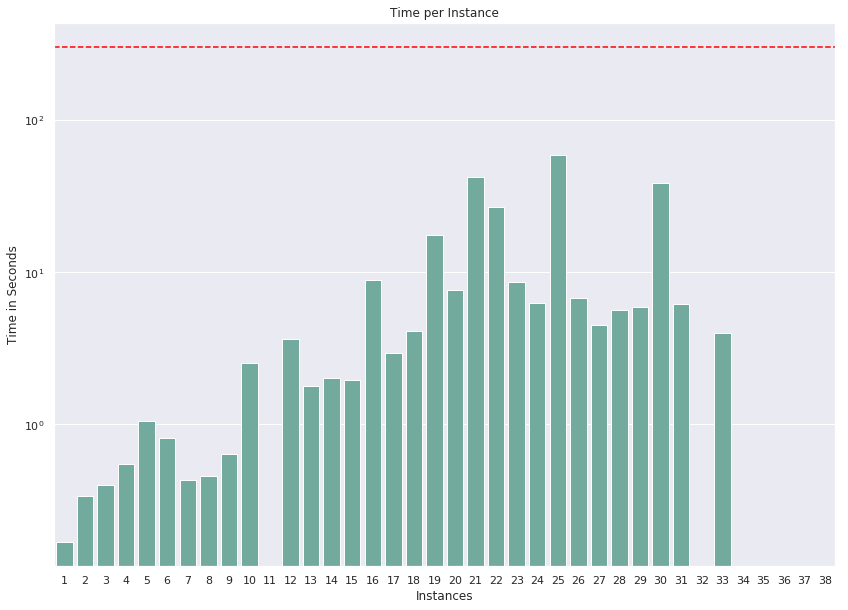

In [11]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# load dataset
tips = sns.load_dataset("tips")

# Set the figure size



plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(
    y=timesr, 
    x=list(range(1,39)),
    estimator=sum, 
    ci=None, 
    color='#69b3a2');

ax.set_yscale("log")
ax.axhline(300, color = 'red', ls = "--")

ax.set(xlabel='Instances', ylabel='Time in Seconds', title="Time per Instance")
plt.show()

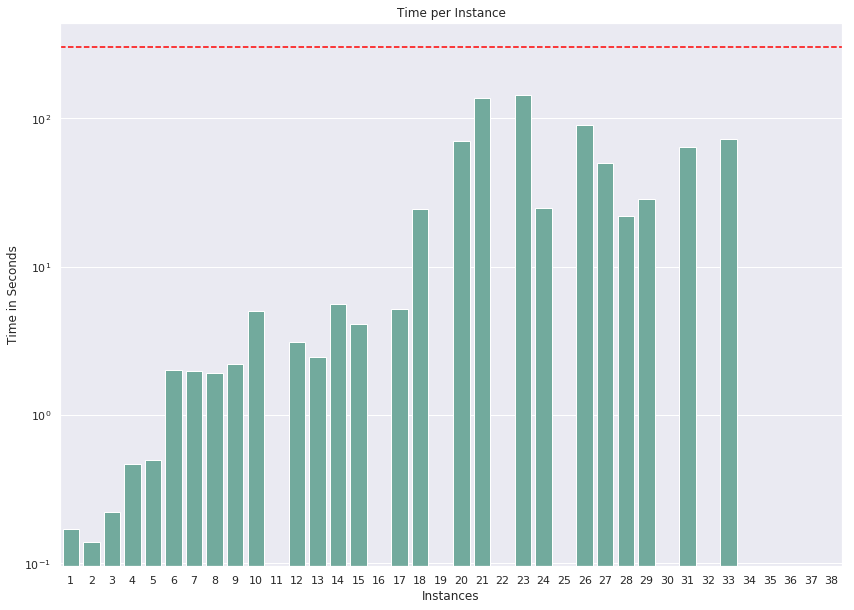

In [12]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# load dataset
tips = sns.load_dataset("tips")

# Set the figure size



plt.figure(figsize=(14, 10))

# plot a bar chart
ax = sns.barplot(
    y=timess, 
    x=list(range(1,39)),
    estimator=sum, 
    ci=None, 
    color='#69b3a2');

ax.set_yscale("log")
ax.axhline(300, color = 'red', ls = "--")

ax.set(xlabel='Instances', ylabel='Time in Seconds', title="Time per Instance")
plt.show()